In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [132]:
df = pd.read_csv("customer_segmentation_data.csv")

df.head()

,Customer ID,Age,Gender,Marital Status,Education Level,Geographic Information,Occupation,Income Level,Behavioral Data,Purchase History,Interactions with Customer Service,Insurance Products Owned,Coverage Amount,Premium Amount,Policy Type,Customer Preferences,Preferred Communication Channel,Preferred Contact Time,Preferred Language,Segmentation Group
0,84966,23,Female,Married,Associate Degree,Mizoram,Entrepreneur,70541,policy5,4/10/2018,Phone,policy2,366603,2749,Group,Email,In-Person Meeting,Afternoon,English,Segment5
1,95568,26,Male,Widowed,Doctorate,Goa,Manager,54168,policy5,11/6/2018,Chat,policy1,780236,1966,Group,Mail,In-Person Meeting,Morning,French,Segment5
2,10544,29,Female,Single,Associate Degree,Rajasthan,Entrepreneur,73899,policy5,6/5/2021,Email,policy3,773926,4413,Group,Email,Mail,Evening,German,Segment3
3,77033,20,Male,Divorced,Bachelor's Degree,Sikkim,Entrepreneur,63381,policy5,9/2/2018,Chat,policy2,787815,4342,Family,Text,In-Person Meeting,Anytime,French,Segment3
4,88160,25,Female,Separated,Bachelor's Degree,West Bengal,Manager,38794,policy1,9/10/2018,Chat,policy4,366506,1276,Family,Email,Text,Weekends,English,Segment2


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53503 entries, 0 to 53502
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Customer ID                         53503 non-null  int64 
 1   Age                                 53503 non-null  int64 
 2   Gender                              53503 non-null  object
 3   Marital Status                      53503 non-null  object
 4   Education Level                     53503 non-null  object
 5   Geographic Information              53503 non-null  object
 6   Occupation                          53503 non-null  object
 7   Income Level                        53503 non-null  int64 
 8   Behavioral Data                     53503 non-null  object
 9   Purchase History                    53503 non-null  object
 10  Interactions with Customer Service  53503 non-null  object
 11  Insurance Products Owned            53503 non-null  ob

In [134]:
df.isnull().sum()

Customer ID                           0
Age                                   0
Gender                                0
Marital Status                        0
Education Level                       0
Geographic Information                0
Occupation                            0
Income Level                          0
Behavioral Data                       0
Purchase History                      0
Interactions with Customer Service    0
Insurance Products Owned              0
Coverage Amount                       0
Premium Amount                        0
Policy Type                           0
Customer Preferences                  0
Preferred Communication Channel       0
Preferred Contact Time                0
Preferred Language                    0
Segmentation Group                    0
dtype: int64

In [135]:
df["Purchase History"] = pd.to_datetime(df["Purchase History"])

df["Purchase History"].head()


0   2018-04-10
1   2018-11-06
2   2021-06-05
3   2018-09-02
4   2018-09-10
Name: Purchase History, dtype: datetime64[ns]

In [136]:
latest_date = df["Purchase History"].max()
latest_date


Timestamp('2023-12-28 00:00:00')

In [137]:
analysis_date = latest_date + pd.Timedelta(days=1)
analysis_date

Timestamp('2023-12-29 00:00:00')

In [138]:
print("Analysis Reference Date:", analysis_date)


Analysis Reference Date: 2023-12-29 00:00:00


In [139]:
rfm = df.groupby("Customer ID").agg({
    "Purchase History": lambda x: (analysis_date - x.max()).days
})
rfm.head()


,Purchase History
Customer ID,
1,31
5,680
23,339
37,179
49,1115


In [140]:
frequency = df.groupby("Customer ID")["Purchase History"].count()
frequency = frequency.rename("Frequency")

rfm = rfm.merge(frequency, on="Customer ID")
rfm.head()


,Purchase History,Frequency
Customer ID,,
1,31,34
5,680,1
23,339,1
37,179,1
49,1115,1


In [141]:
monetary = df.groupby("Customer ID")["Premium Amount"].sum()
monetary = monetary.rename("Monetary")

rfm = rfm.merge(monetary, on="Customer ID")
rfm.head()


,Purchase History,Frequency,Monetary
Customer ID,,,
1,31,34,110417
5,680,1,3713
23,339,1,2791
37,179,1,1897
49,1115,1,4512


In [165]:
rfm = rfm[["Purchase History", "Frequency", "Monetary"]]
rfm

,Purchase History,Frequency,Monetary
Customer ID,,,
1,31,34,110417
5,680,1,3713
23,339,1,2791
37,179,1,1897
49,1115,1,4512
...,...,...,...
99772,865,1,1625
99891,1345,1,2270
99962,1414,1,4844


In [171]:
rfm["R_Score"] = pd.qcut(rfm["Purchase History"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

rfm.head()


,Purchase History,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
1,31,34,110417,5,5,5,555
5,680,1,3713,4,1,3,413
23,339,1,2791,5,1,2,512
37,179,1,1897,5,1,1,511
49,1115,1,4512,3,1,4,314


In [174]:
def segment_customer(row):
    r, f, m = int(row["R_Score"]), int(row["F_Score"]), int(row["M_Score"])
    
    if r >= 4 and f >= 4 and m >= 4:
        return "Best Customer"
    elif r >= 4 and f >= 3:
        return "Loyal Customer"
    elif r >= 4:
        return "Potential"
    elif r <= 2 and f <= 2 and m <= 2:
        return "Lost"
    elif f >= 4:
        return "Frequent Buyer"
    else:
        return "Others"


In [176]:
rfm["Segment"] = rfm.apply(segment_customer, axis=1)


In [177]:
rfm[["RFM_Score", "Segment"]].head(10)


,RFM_Score,Segment
Customer ID,,
1,555,Best Customer
5,413,Potential
23,512,Potential
37,511,Potential
49,314,Others
53,413,Potential
65,311,Others
87,511,Potential
158,112,Lost


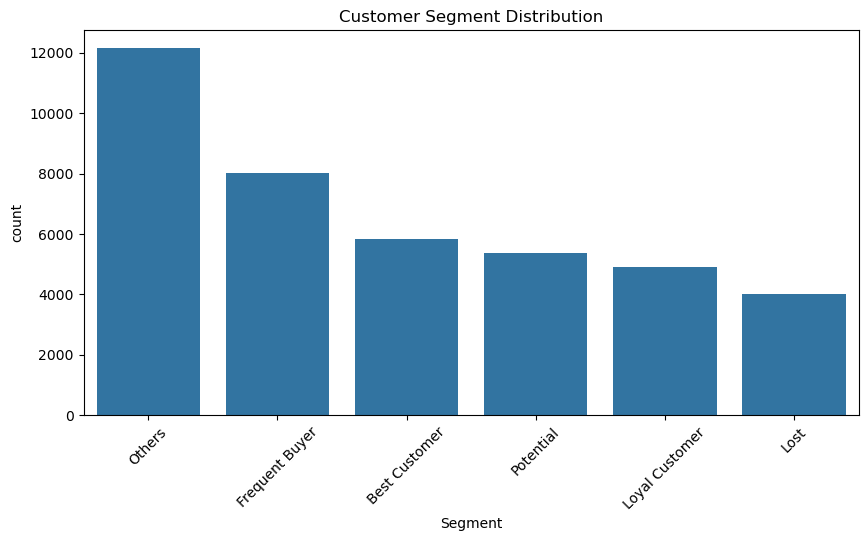

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index)
plt.title("Customer Segment Distribution")
plt.xticks(rotation=45)
plt.show()


In [189]:

df["Purchase History"] = pd.to_datetime(df["Purchase History"])
df["Year"] = df["Purchase History"].dt.year


In [191]:
df["Month"] = df["Purchase History"].dt.month


def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["Season"] = df["Month"].apply(get_season)


In [193]:
df[["Purchase History", "Year", "Month", "Season"]].head()


,Purchase History,Year,Month,Season
0,2018-04-10,2018,4,Spring
1,2018-11-06,2018,11,Autumn
2,2021-06-05,2021,6,Summer
3,2018-09-02,2018,9,Autumn
4,2018-09-10,2018,9,Autumn


In [195]:
df[["Geographic Information", "Premium Amount", "Policy Type", "Gender", "Year"]].isnull().sum()



Geographic Information    0
Premium Amount            0
Policy Type               0
Gender                    0
Year                      0
dtype: int64

In [199]:
df.to_csv("cleaned_customer_data.csv", index=False)
